# Optimize

run and compare optimization frameworks

- hyperopt
- optuna
- nevergrad
- platypus
- scipy (Powell)
- ax


In [1]:
from datetime import datetime
from functools import partial

import pytest
import numpy as np
import pandas as pd
import scipy
# import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

# TODO:
# simulates take override simulation args
# redo history several times without reinitializing with different parameters
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them
# chart - show strategy, fixed, var, stock, add optimizer to title
# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time
# do with deathrate
# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))

numpy 1.19.2
pandas 1.2.1
scipy 1.6.0


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [4]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011522
1929,-0.082979,0.030179,0.000000
1930,-0.251236,0.005398,-0.026712
1931,-0.438375,-0.156808,-0.089321
1932,-0.086424,0.235896,-0.103014
...,...,...,...
2016,0.117731,0.103651,0.012616
2017,0.216055,0.097239,0.021301
2018,-0.042269,-0.027626,0.024426


In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454874,0.044227
1929,-0.082979,0.030179
1930,-0.230686,0.032991
1931,-0.383290,-0.074106
1932,0.018495,0.377832
...,...,...
2016,0.103805,0.089901
2017,0.190692,0.074354
2018,-0.065104,-0.050811


In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30
from functools import partial

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {'gamma': gamma},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


In [7]:
from scipy import optimize
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method
# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))



2021-02-11 05:32:31 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations
2021-02-11 05:32:35 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.256642
2021-02-11 05:32:35 best value -15532.416056, best params [0.         6.20410477 1.        ]
2021-02-11 05:32:35 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations
2021-02-11 05:32:41 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 11 iterations in 0:00:06.003812
2021-02-11 05:32:41 best value -13517.859788, best params [0.29525622 6.23946488 1.        ]
2021-02-11 05:32:41 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations
2021-02-11 05:33:17 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 9 iterations in 0:00:36.609855
2021-02-11 05:33:17 best value -12025.059375, best params [1.97819245 4.68360751 1.        ]
2021-02-11 05:33:17 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations
2021-02-11 05:35:35 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 4,

In [8]:
results_dict = {}

In [9]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,0.000000,0.000000,6.204105,-15532.416056
1,1,1.000000,0.000000,0.295256,6.239465,-13517.859788
2,2,1.000000,0.000000,1.978192,4.683608,-12025.059375
3,4,0.890329,0.109671,2.615586,3.199853,-10318.960483
4,6,0.816227,0.183773,3.000149,2.265998,-9574.406354
5,8,0.785537,0.214463,3.189183,1.832006,-9163.998667
6,10,0.780733,0.219267,3.325579,1.528700,-8906.502051
7,12,0.902840,0.097160,2.662791,3.077804,-7980.752622
8,14,0.753638,0.246362,3.498058,1.154463,-8603.485065
9,16,0.754683,0.245317,3.556905,1.029985,-8506.558096


In [10]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-13517.859787576608

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7fd650515120>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.5569047950517922,
 'fixed_pct': 3.556904795051792,
 'variable': 0.010299845651512636,
 'variable_pct': 1.0299845651512636}
mean annual spending over all cohorts 4.94
0.00% of portfolios exhausted by final year


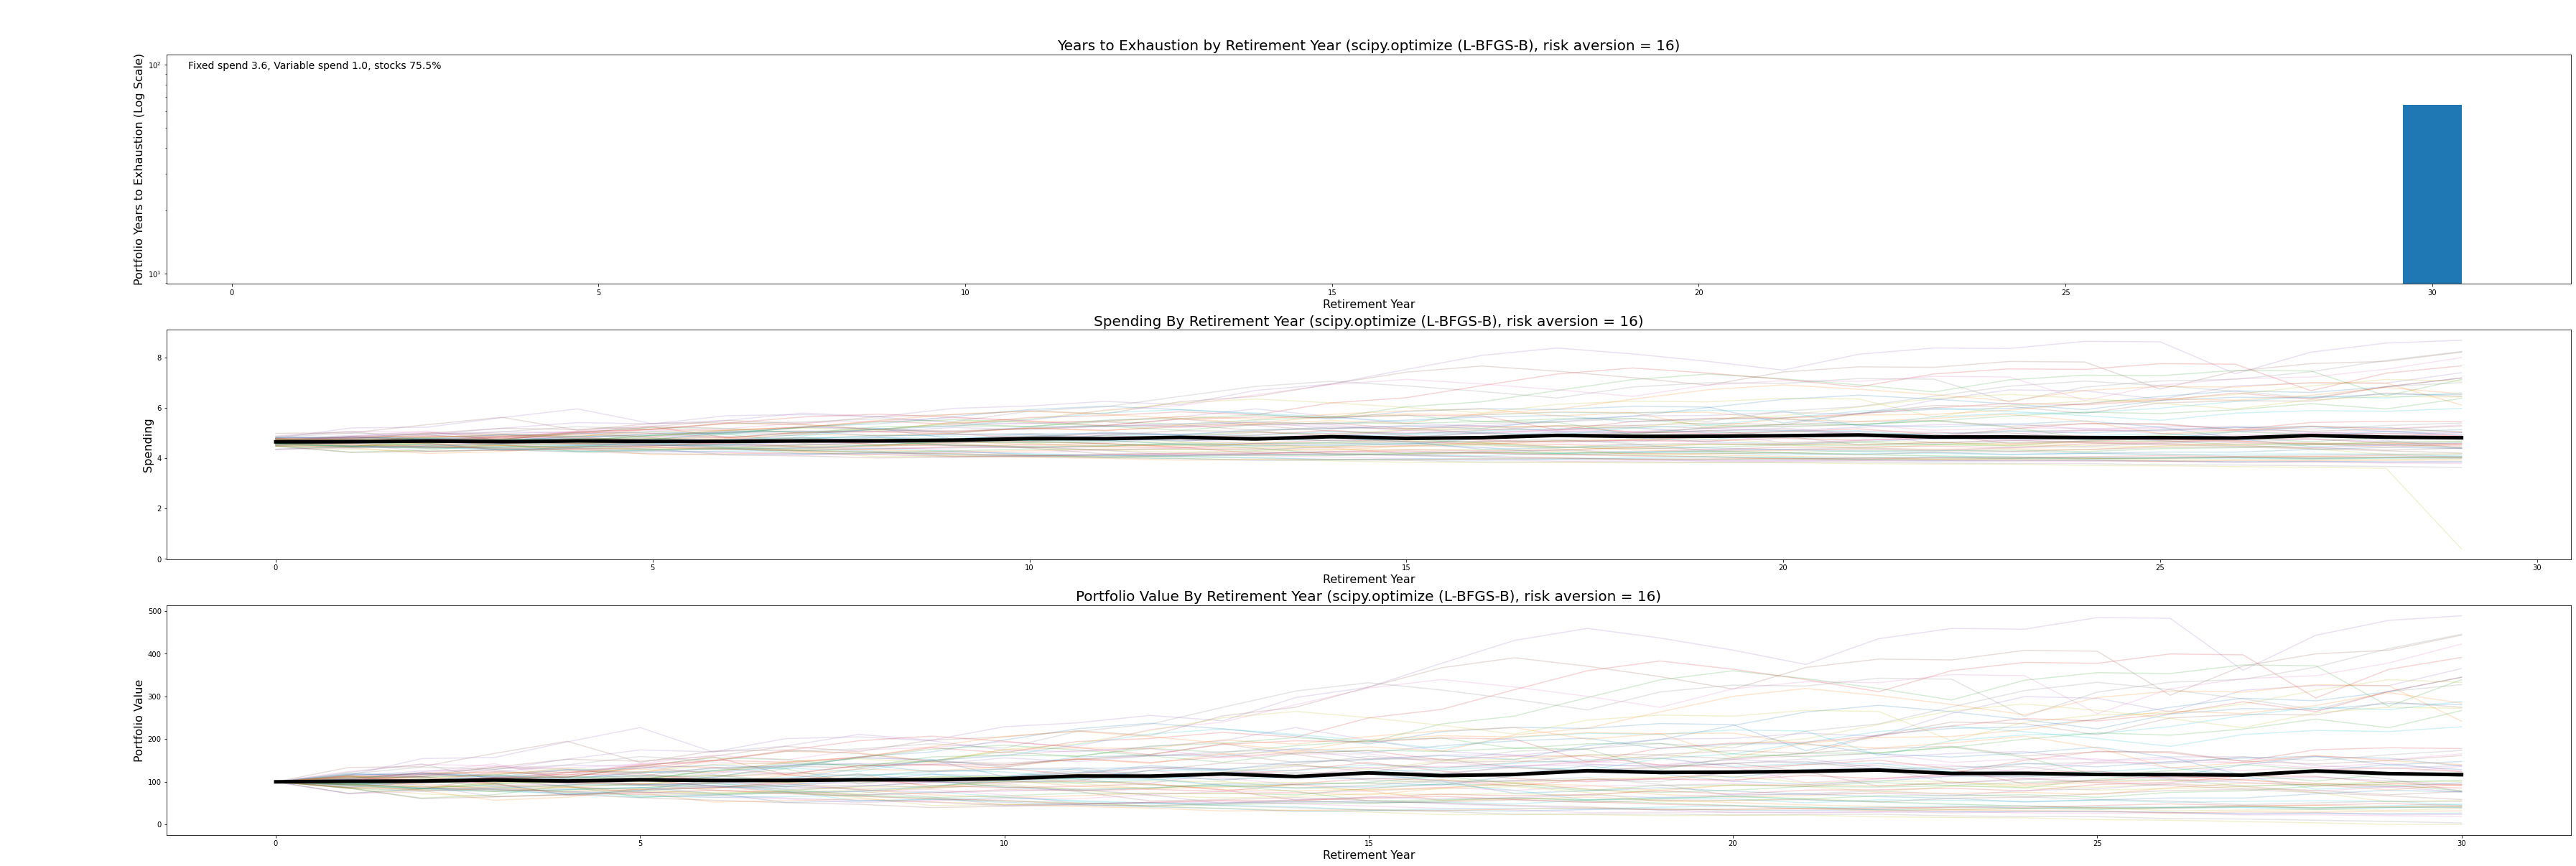

In [11]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    
    'analysis': {'histogram': True, 
                     'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                  'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                          VARIABLE_SPEND, 
                                                                                                          100 * ALLOC_STOCKS)
                                 },
                     'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                 },
                     'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                 },
                }    
})

print(s)

s.simulate()

s.analyze()


In [12]:
s.evaluation

{'gamma': 16.0}

In [13]:
import optuna   # https://optuna.org/
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))
    

optuna 2.5.0
2021-02-11 05:41:01 Starting Optuna, gamma 0, 1000 trials
2021-02-11 05:43:09 Finishing optimizer Optuna, gamma 0, 1000 trials in 0:02:08.030485
2021-02-11 05:43:09 best value -15531.583560, best params {'fixed_spend': 0.0006423890957112316, 'variable_spend': 6.250641916214324, 'alloc_stocks': 0.9999674128829478}
2021-02-11 05:43:09 Starting Optuna, gamma 1, 1000 trials
2021-02-11 07:03:07 Finishing optimizer Optuna, gamma 1, 1000 trials in 1:19:58.671261
2021-02-11 07:03:07 best value -13516.485716, best params {'fixed_spend': 0.1592449864934082, 'variable_spend': 6.365816855575826, 'alloc_stocks': 0.9998141640083179}
2021-02-11 07:03:07 Starting Optuna, gamma 2, 1000 trials
2021-02-11 07:06:45 Finishing optimizer Optuna, gamma 2, 1000 trials in 0:03:38.102732
2021-02-11 07:06:45 best value -12034.797435, best params {'fixed_spend': 2.034926025968012, 'variable_spend': 4.466247849173355, 'alloc_stocks': 0.9997630127582139}
2021-02-11 07:06:45 Starting Optuna, gamma 4, 100

In [14]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999967,0.000033,0.000642,6.250642,-15531.583560
1,1,0.999814,0.000186,0.159245,6.365817,-13516.485716
2,2,0.999763,0.000237,2.034926,4.466248,-12034.797435
3,4,0.889986,0.110014,2.682392,3.030550,-10326.343086
4,6,0.801328,0.198672,2.963646,2.354669,-9571.561490
5,8,0.796691,0.203309,3.192967,1.815458,-9159.551860
6,10,0.759276,0.240724,3.297291,1.593883,-8903.253768
7,12,0.766352,0.233648,3.378866,1.407192,-8726.087469
8,14,0.763575,0.236425,3.520649,1.108164,-8602.314348
9,16,0.738305,0.261695,3.576131,0.987451,-8505.248029


In [15]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-13516.485716079324

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7fd670514270>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.5761306431941904,
 'fixed_pct': 3.5761306431941904,
 'variable': 0.009874512958013774,
 'variable_pct': 0.9874512958013775}
mean annual spending over all cohorts 4.91
0.00% of portfolios exhausted by final year


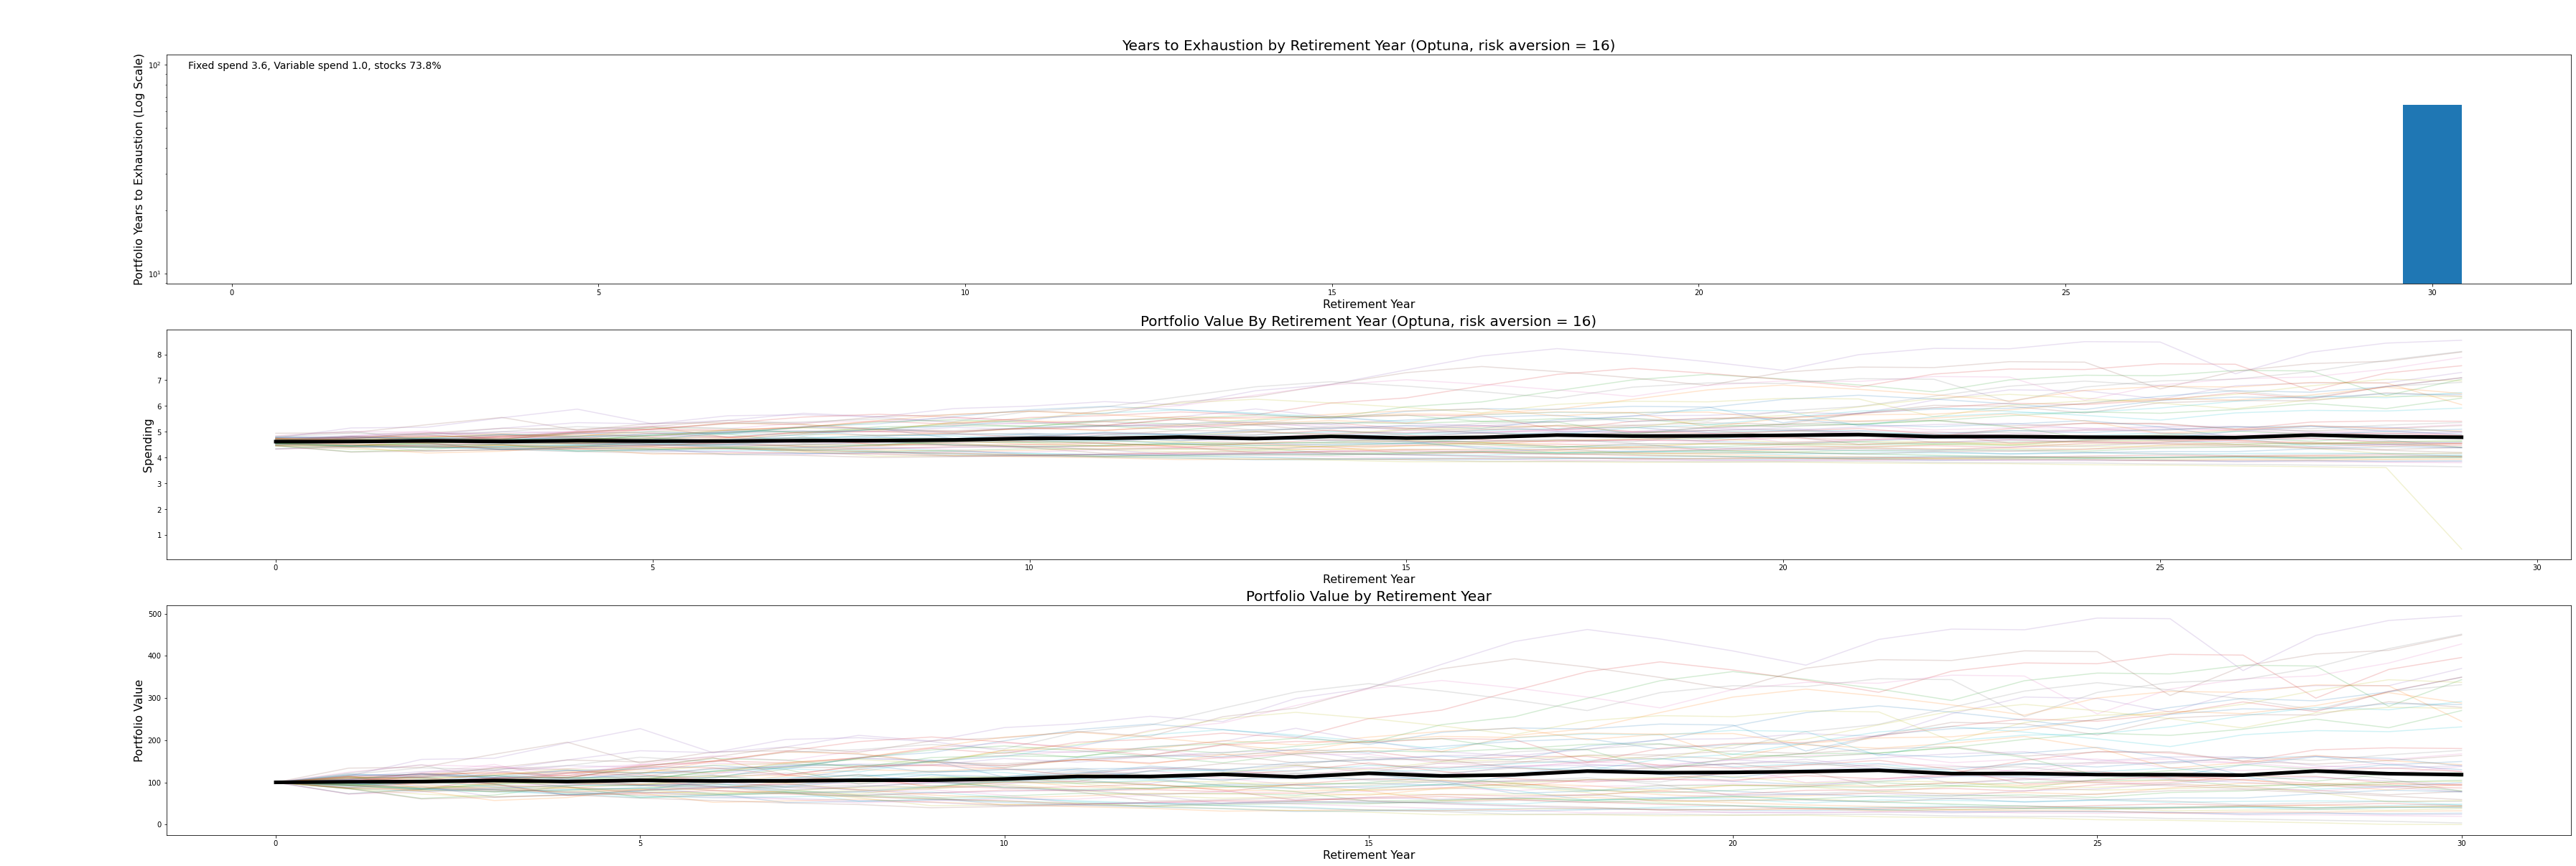

In [16]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()

s.analyze()

In [17]:
import hyperopt  # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study.best_params))
        

hyperopt 0.2.5
2021-02-11 07:34:37 Starting Hyperopt, gamma 0, 1000 trials
100%|██████████| 1000/1000 [03:29<00:00,  4.77trial/s, best loss: -15530.387758461266]
2021-02-11 07:38:07 Finishing optimizer Hyperopt, gamma 0, 1000 trials in 0:03:29.739273
2021-02-11 07:38:07 best params {'fixed_spend': 3.5761306431941904, 'variable_spend': 0.9874512958013775, 'alloc_stocks': 0.7383053848928176}
2021-02-11 07:38:07 Starting Hyperopt, gamma 1, 1000 trials
100%|██████████| 1000/1000 [03:19<00:00,  5.01trial/s, best loss: -13511.520186215565]
2021-02-11 07:41:27 Finishing optimizer Hyperopt, gamma 1, 1000 trials in 0:03:19.761450
2021-02-11 07:41:27 best params {'fixed_spend': 3.5761306431941904, 'variable_spend': 0.9874512958013775, 'alloc_stocks': 0.7383053848928176}
2021-02-11 07:41:27 Starting Hyperopt, gamma 2, 1000 trials
100%|██████████| 1000/1000 [03:26<00:00,  4.83trial/s, best loss: -12034.96289412841]
2021-02-11 07:44:54 Finishing optimizer Hyperopt, gamma 2, 1000 trials in 0:03:26.9

In [18]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
study_values = []
for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999857,0.000143,0.002108,6.193761,-15530.387758
1,1,0.999384,0.000616,0.690291,5.875615,-13511.520186
2,2,0.999603,0.000397,2.077627,4.345954,-12034.962894
3,4,0.908693,0.091307,2.598299,3.174565,-10305.233397
4,6,0.768201,0.231799,3.012394,2.205298,-9550.396699
5,8,0.841152,0.158848,3.094592,2.046736,-9139.039893
6,10,0.736411,0.263589,3.286232,1.616255,-8899.494362
7,12,0.744839,0.255161,3.437152,1.295575,-8711.109216
8,14,0.707901,0.292099,3.507762,1.128389,-8597.661255
9,16,0.804573,0.195427,3.631580,0.871447,-8490.935321


In [19]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-13511.520186215565

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7fd641597ba0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.6315801101634815,
 'fixed_pct': 3.6315801101634815,
 'variable': 0.008714472715006477,
 'variable_pct': 0.8714472715006476}
mean annual spending over all cohorts 4.82
0.00% of portfolios exhausted by final year


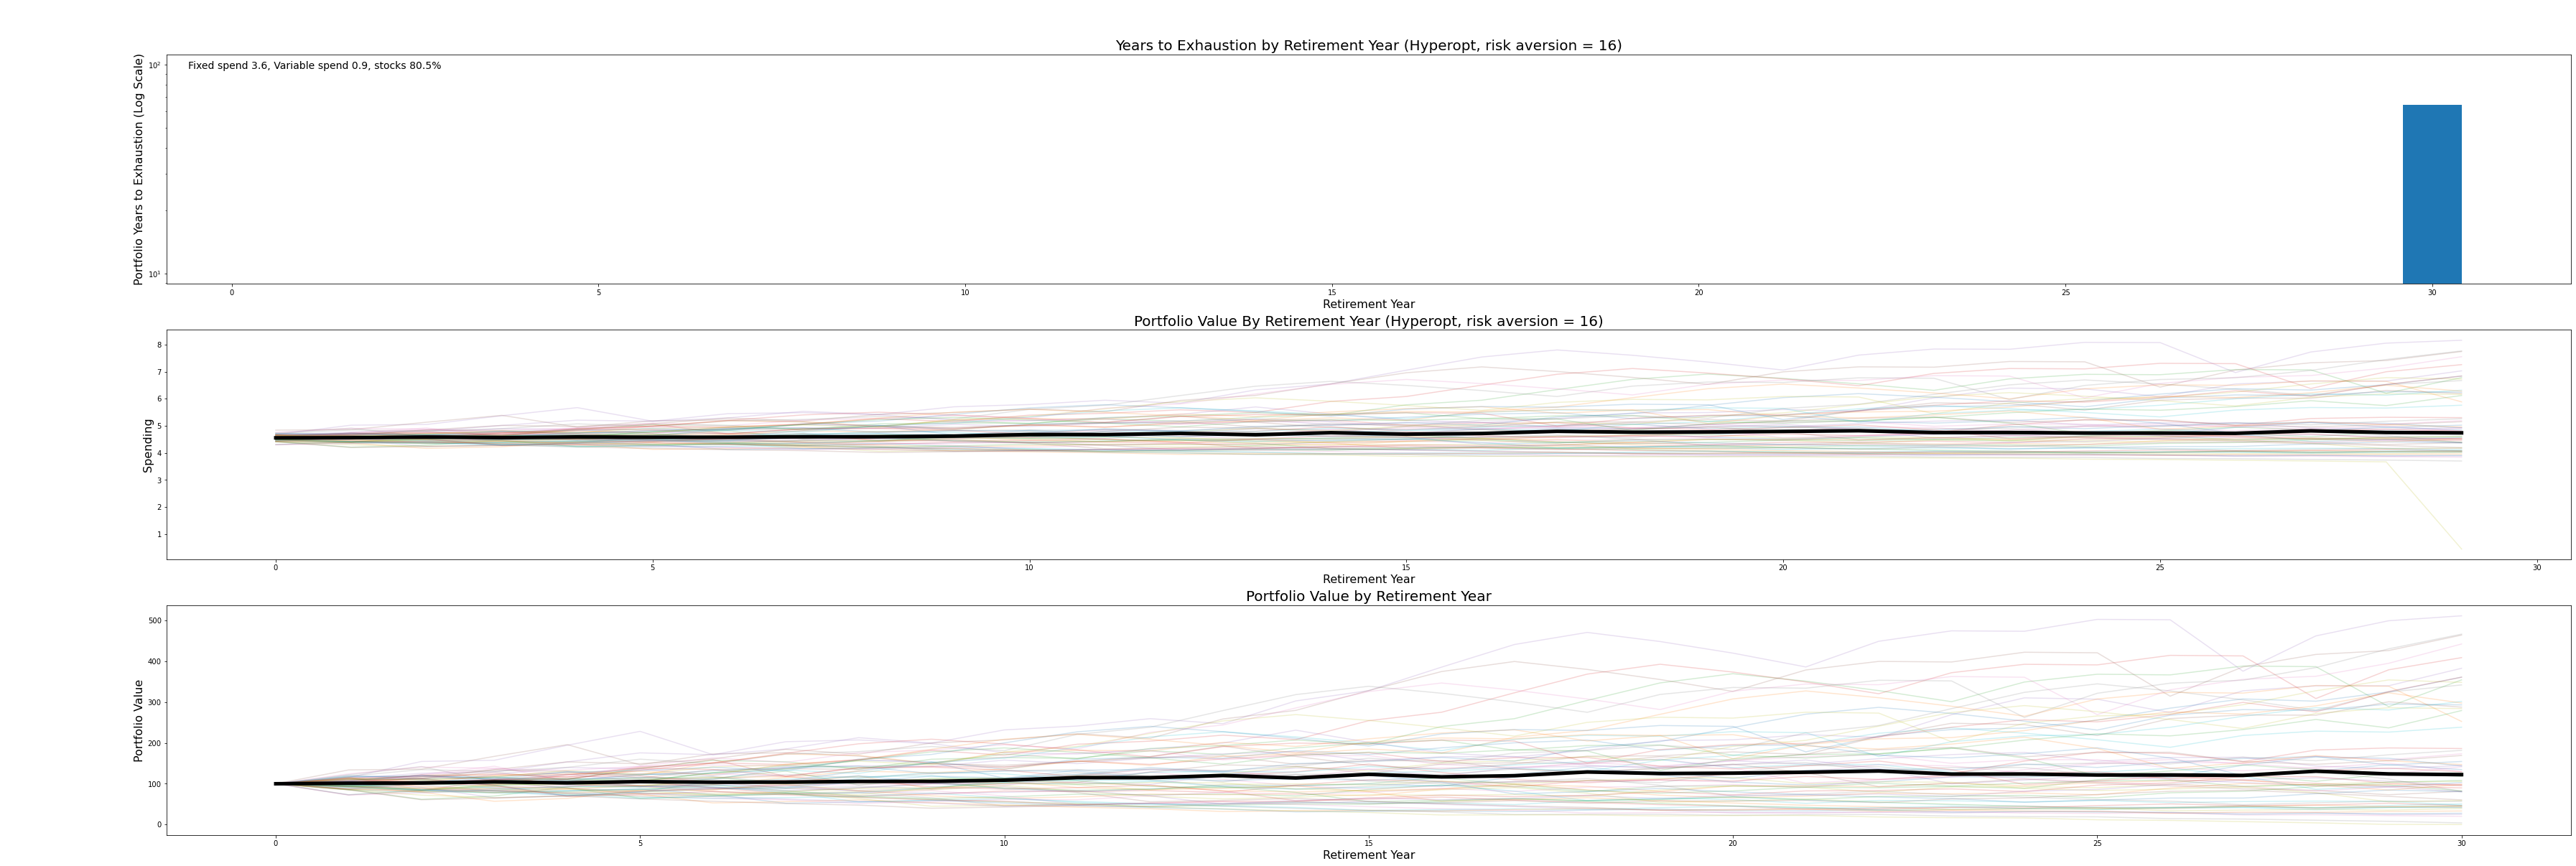

In [20]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [22]:
# https://github.com/Project-Platypus/Platypus
import platypus
from platypus import MOEAD, Problem, Real
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))


ImportError: cannot import name 'MOEAD' from 'platypus' (/Users/drucev/opt/anaconda3/envs/optimizers/lib/python3.8/site-packages/platypus/__init__.py)

In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

In [ ]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


In [ ]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [ ]:
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
print("%s %s" % ("nevergrad", ng.__version__))

from concurrent import futures

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        


In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results


In [ ]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


In [ ]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [ ]:
import ax  # https://ax.dev/
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 10  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))


In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

In [ ]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


In [ ]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [ ]:
import dlib
# http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html?m=1
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))




In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

In [ ]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


In [ ]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': GAMMA},
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [ ]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



In [ ]:
# plot all results
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, all optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
for opt in results_dict.keys():
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [ ]:
results_dict.keys()

In [ ]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']

In [ ]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
all_results.loc[all_results['value'] == all_results['group_gamma_max']]